In [2]:
# Download all the libraries and packages needed
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [3]:
# loading cherry_blossoms dataset
ds = tfds.load("cherry_blossoms", split='train')
ds

<_PrefetchDataset element_spec={'doy': TensorSpec(shape=(), dtype=tf.float32, name=None), 'temp': TensorSpec(shape=(), dtype=tf.float32, name=None), 'temp_lower': TensorSpec(shape=(), dtype=tf.float32, name=None), 'temp_upper': TensorSpec(shape=(), dtype=tf.float32, name=None), 'year': TensorSpec(shape=(), dtype=tf.int32, name=None)}>

In [4]:
# Convert tf.data.cherry_blossoms to a panda dataframe
df = tfds.as_dataframe(ds)
df.head()

,doy,temp,temp_lower,temp_upper,year
0,NaN,6.46,4.76,8.16,1300
1,105.0,5.63,4.90,6.37,1638
2,109.0,5.81,4.68,6.95,1347
3,104.0,5.70,4.87,6.53,1187
4,107.0,6.20,5.31,7.09,1617


In [5]:
# list of the dataframe shape, size and other info
df.info()

<class 'tensorflow_datasets.core.as_dataframe.as_dataframe.<locals>.StyledDataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   doy         827 non-null    float32
 1   temp        1124 non-null   float32
 2   temp_lower  1124 non-null   float32
 3   temp_upper  1124 non-null   float32
 4   year        1215 non-null   int32  
dtypes: float32(4), int32(1)
memory usage: 23.9 KB


In [6]:
# Dataset analysis
df.describe()

,doy,temp,temp_lower,temp_upper,year
count,827.000000,1124.000000,1124.000000,1124.000000,1215.000000
mean,104.540504,6.141886,5.098941,7.185151,1408.000000
std,6.407036,0.663648,0.850350,0.992921,350.884596
min,86.000000,4.670000,0.750000,5.450000,801.000000
25%,100.000000,5.700000,4.610000,6.480000,1104.500000
50%,105.000000,6.100000,5.145000,7.040000,1408.000000
75%,109.000000,6.530000,5.542500,7.720000,1711.500000
max,124.000000,8.300000,7.740000,12.100000,2015.000000


In [7]:
# Drop all not needed feauters
df = df.drop(columns=['doy', 'temp_upper', 'year'])
df.head()

,temp,temp_lower
0,6.46,4.76
1,5.63,4.90
2,5.81,4.68
3,5.70,4.87
4,6.20,5.31


In [8]:
# CaLculating Correlation
df.corr()

,temp,temp_lower
temp,1.000000,0.663891
temp_lower,0.663891,1.000000


In [9]:
# Correlation between all pairs
# Pair of least correlation (-0.499087) - is the pair year-temp_upper 
# Pair of highest correlation (0.767866) - is the pair temp-temp_upper 
corrDF = tfds.as_dataframe(ds)
corrDF.corr()

,doy,temp,temp_lower,temp_upper,year
doy,1.000000,-0.326976,-0.271967,-0.294773,-0.052139
temp,-0.326976,1.000000,0.663891,0.767866,-0.066062
temp_lower,-0.271967,0.663891,1.000000,0.030739,0.479762
temp_upper,-0.294773,0.767866,0.030739,1.000000,-0.499087
year,-0.052139,-0.066062,0.479762,-0.499087,1.000000


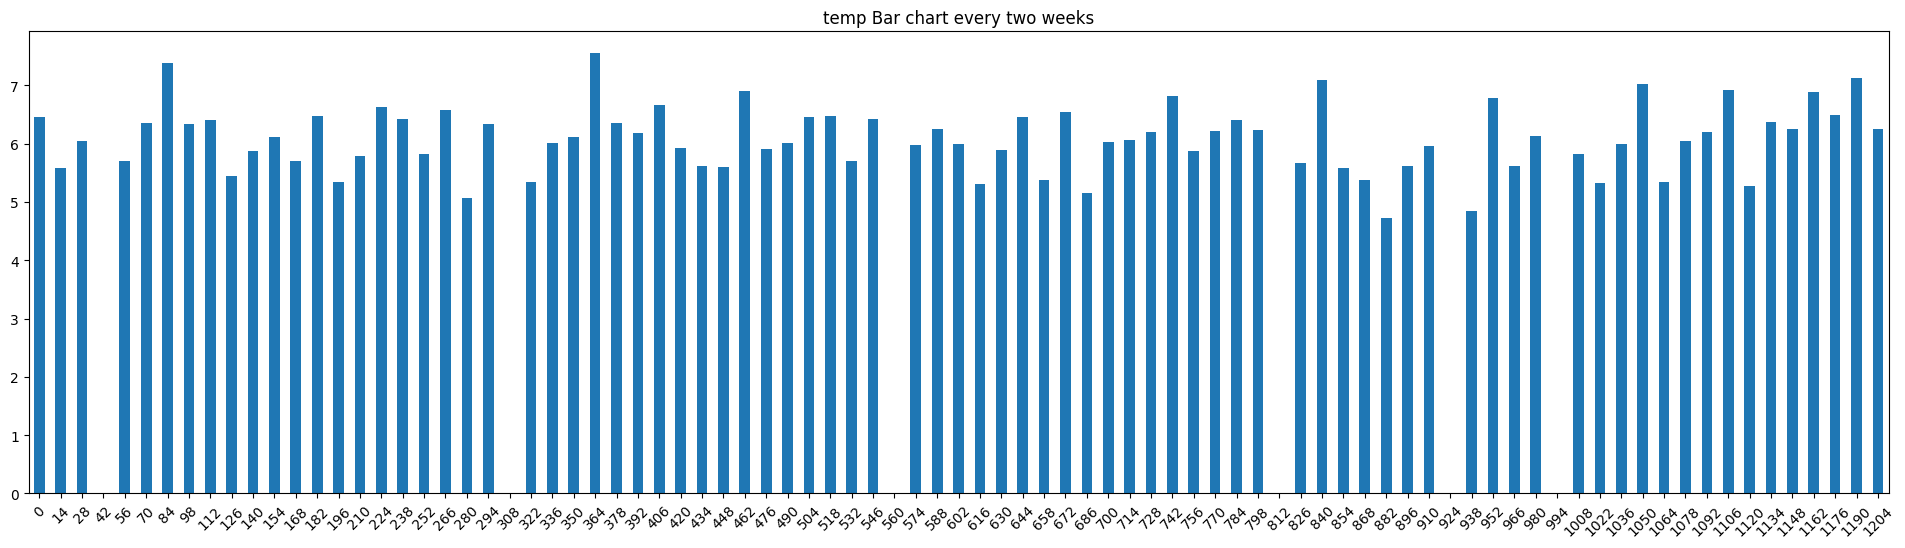

In [10]:
# Bar chart for independant variable temp
subset_df = df[::14]  # Select every 14th row (2 weeks)
plt.figure(figsize=(24, 6))  # Set the figure size (width=12, height=6)

# Create a bar plot of the 'temp' column from subset_df
subset_df['temp'].plot.bar(title='temp Bar chart every two weeks')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)  # Rotate labels by 45 degrees
plt.show()

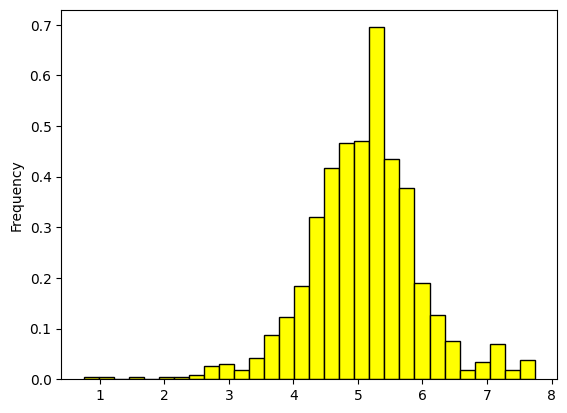

In [11]:
# Empirical distribution function for dependant variable temp_lower
df['temp_lower'].plot.hist(color='yellow', edgecolor='black', bins=30, density=True);

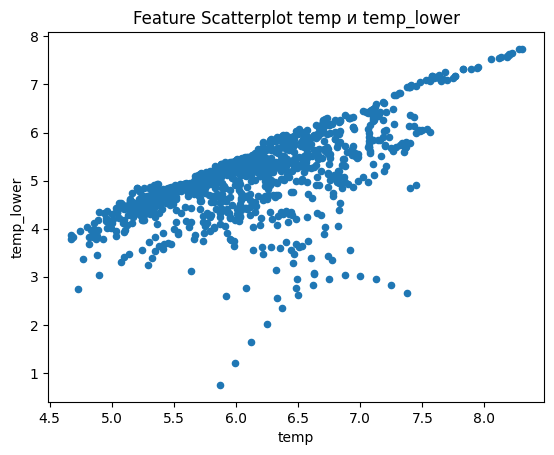

In [12]:
# Feature Scatterplot for temp and temp_lower
df.plot.scatter('temp','temp_lower',title='Feature Scatterplot temp и temp_lower');

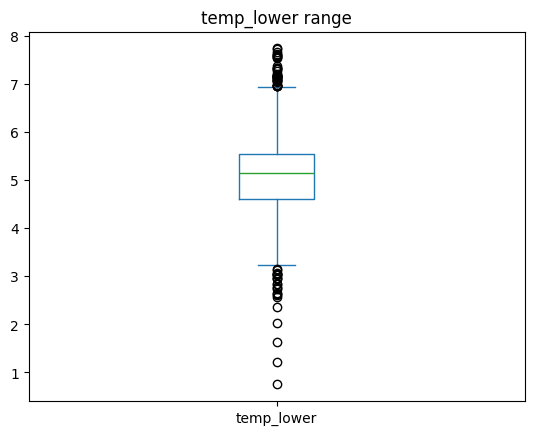

In [13]:
# We can see that we have a few outlier points that we need to remove
df['temp_lower'].plot.box(title='temp_lower range');

In [14]:
# we make temp and temp-lower columns into numpy arrays
x = df['temp'].values
y = df['temp_lower'].values
x.shape, y.shape

((1215,), (1215,))

In [15]:
# condiations
conditionOne = (y > 3)
conditionTwo = (y < 7)

In [16]:
x = x[conditionOne & conditionTwo]
y = y[conditionOne & conditionTwo]
x.shape, y.shape

((1074,), (1074,))

Text(0.5, 1.0, 'Scatter Plot')

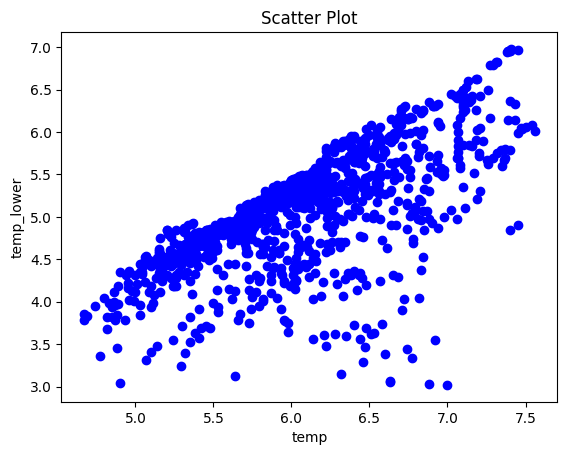

In [17]:
plt.scatter(x, y, color='blue')
plt.xlabel('temp')  # Customize x-axis label
plt.ylabel('temp_lower')  # Customize y-axis label
plt.title('Scatter Plot') 

In [18]:
# Lets build a simple linear regression model that uses an analytical method to predicte y values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((859,), (859,), (215,), (215,))

In [20]:
class SimpleLinReg:

    def __init__(self):
        self.a_ = None
        self.b_ = None

    def fit(self, x_train, y_train):
        assert x_train.ndim == 1, \
            "В данных должен быть один признак"
        assert len(x_train) == len(y_train), \
            "Данные должны иметь одинаковый размер"

        x_mean = np.mean(x_train)
        y_mean = np.mean(y_train)

        self.a_ = (x_train - x_mean).dot(y_train - y_mean) / \
                  (x_train - x_mean).dot(x_train - x_mean)
        self.b_ = y_mean - self.a_ * x_mean

        return self

    def predict(self, x_predict):
        assert x_predict.ndim == 1, \
            "В данных должен быть один признак"
        assert self.a_ is not None and self.b_ is not None, \
            "Модель вначале должна быть обучена"

        return np.array([self._predict(x) for x in x_predict])

    def _predict(self, x_single):
        return self.a_ * x_single + self.b_

    def __repr__(self):
        return "SimpleLinearReg()"

In [21]:
reg1 = SimpleLinReg()
reg1

SimpleLinearReg()

In [23]:
reg1.fit(x, y)
reg1.a_, reg1.b_

(0.7783424, 0.3360138)

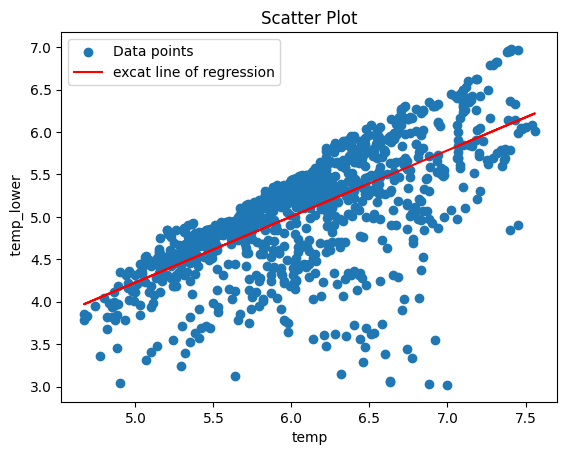

In [25]:
plt.scatter(x, y, label='Data points')
plt.plot(x, reg1.predict(x), color='r', label='excat line of regression')
plt.xlabel('temp')  # Customize x-axis label
plt.ylabel(' temp_lower')  # Customize y-axis label
plt.title('Scatter Plot')
plt.legend()
plt.legend(loc='upper left')

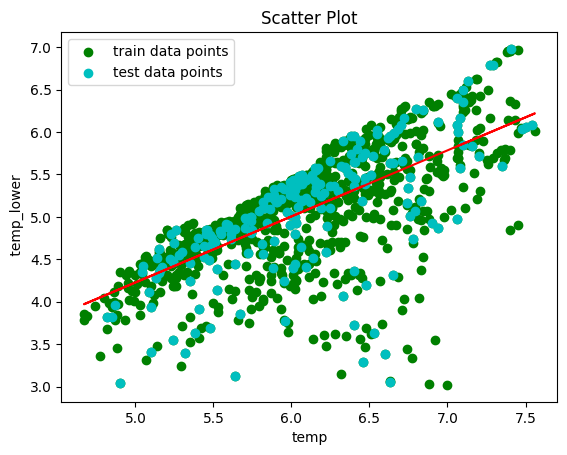

In [27]:
plt.scatter(x, y, color='g', label='train data points')
plt.scatter(x_test, y_test, color='c',label='test data points')
plt.plot(x, reg1.predict(x), color='r');
plt.xlabel('temp')  # Customize x-axis label
plt.ylabel(' temp_lower')  # Customize y-axis label
plt.title('Scatter Plot')
plt.legend()
plt.legend(loc='upper left')

In [28]:
# Let's calcuclate prediction values for the test set points to assess the quality of the regression model
y_predict = reg1.predict(x_test)
y_predict

array([4.6013303, 5.0761194, 5.434157 , 4.655814 , 5.6365256, 5.659876 ,
       5.620959 , 5.044986 , 5.216221 , 4.889317 , 5.309622 , 5.0605526,
       5.0605526, 5.8466783, 5.021635 , 5.371889 , 4.57798  , 5.3563223,
       5.838895 , 4.6091137, 5.5197744, 4.865967 , 5.037202 , 4.725865 ,
       4.4223113, 4.9204507, 4.593547 , 4.7492156, 5.1461697, 4.414528 ,
       5.496424 , 5.7377105, 5.994563 , 5.511991 , 5.0683355, 5.348539 ,
       5.940079 , 4.9204507, 4.998285 , 5.862245 , 4.788132 , 5.099469 ,
       4.461229 , 4.6480308, 5.2707047, 5.3563223, 4.328911 , 5.488641 ,
       4.398961 , 5.2629213, 4.430095 , 5.8466783, 4.9204507, 5.8855953,
       6.2047157, 5.021635 , 5.006068 , 5.8311114, 5.511991 , 5.239571 ,
       5.628742 , 5.107253 , 4.8815336, 4.500146 , 4.7725654, 4.5701966,
       5.044986 , 4.998285 , 5.317405 , 4.336694 , 4.967151 , 6.173582 ,
       4.9749346, 5.5586915, 4.865967 , 4.1109743, 5.410806 , 4.87375  ,
       4.6013303, 5.200654 , 5.2862716, 4.6869483, 

In [29]:
# Mean Absolute Error, MAE
mae_test = np.sum(np.absolute(y_predict - y_test))/len(y_test)
mae_test

0.38121994373410245

In [30]:
# Mean Squared Error, MSE
mse_test = np.sum((y_predict - y_test)**2) / len(y_test)
mse_test

0.2834579822628997

In [31]:
# Coefficient of determination measures the proportion of variance explained by the model in the total variance of the target variable.
1 - mse_test/np.var(y_test)

0.4625992170988761

In [32]:
# The model is only able to explain approximately 46.26% of the variance in the test data which is bad.

In [33]:
print(tf.__version__)

2.16.1


In [34]:
# Let's build a simple linear regression model that uses a simple neural network with one layer that has one neutron

In [35]:
# We use keras API sequential model which means a sequence of layers, where the output of each layer becomes the input to the next layer.
# A dense layer is a fully connected layer meaning each neuron is connected to every neuron in the previous layer

# Input shape (1,) for a single input feature
input_shape = (1,)

# Create thru Keras' API a Sequential model
model = tf.keras.Sequential()

# Add the Input layer specifying the input shape
model.add(tf.keras.Input(shape=input_shape))

# Add a Dense layer with 1 neuron (output) to perform linear regression
model.add(tf.keras.layers.Dense(1))

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# The two parameters are Weight and Bias

In [37]:
# Let's set up the process of its training by calling the compile() method:
model.compile(
    loss=tf.keras.losses.mean_absolute_error,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.25),
    metrics=['mean_absolute_error']
)

In [38]:
# Here, the mean absolute error MAE is used as a loss function (error) and to assess the quality of the model.
# The model can be trained on the training data using the fit() method:
model.fit(x, y, epochs=100) # verbose=0

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 4.0600 - mean_absolute_error: 4.0600   
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.5258 - mean_absolute_error: 0.5258  
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.3534 - mean_absolute_error: 0.3534
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 0.3792 - mean_absolute_error: 0.3792
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.3889 - mean_absolute_error: 0.3889
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.3583 - mean_absolute_error: 0.3583
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - loss: 0.3459 - mean_absolute_error: 0.3459
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 0.3960 - mean_absolute_error: 0.3960
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 0.3771 - mean_absolute_error: 0.3771
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.4242 - mean_absolute_error: 0.4242
Epoch 11/100
34/34

In [39]:
# At the beginning the loss was 4.0600  and by the end it got slightly better (i.e. lower) 0.3880

In [40]:
# Let's predict the values of the dependent variable (response) and display the first 10 predictions 
y_predict2 = model.predict(x_test)
y_predict2[:10]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([[4.433504 ],
       [4.9083185],
       [5.2663755],
       [4.487991 ],
       [5.4687552],
       [5.492107 ],
       [5.4531875],
       [4.8771834],
       [5.0484276],
       [4.721506 ]], dtype=float32)

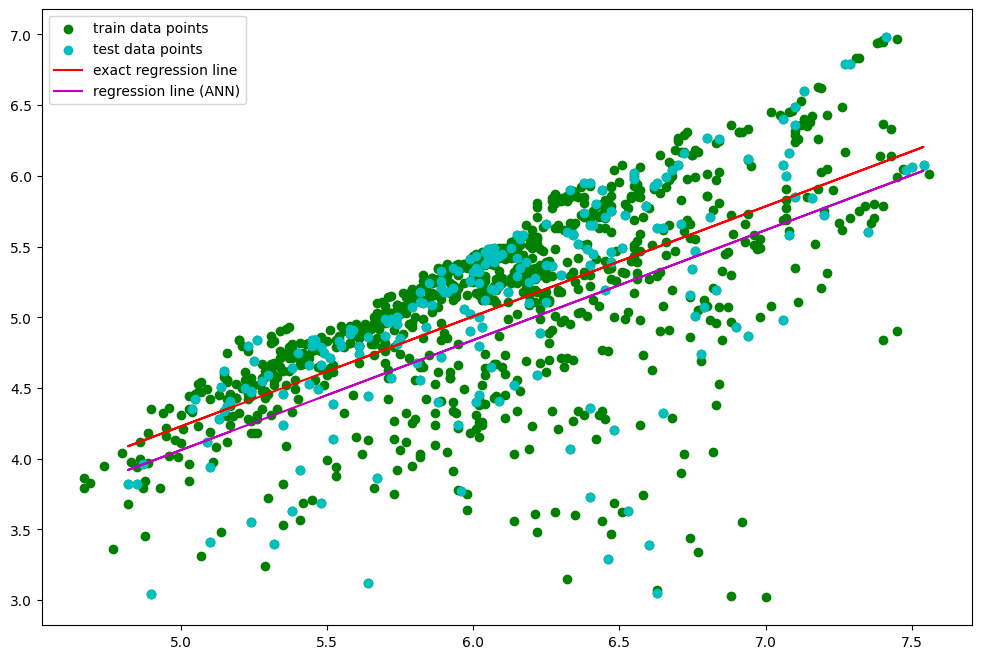

In [41]:
plt.figure(figsize=(12,8))
plt.scatter(x, y, color='g', label='train data points')
plt.scatter(x_test, y_test, color='c',label='test data points')
plt.plot(x_test, y_predict, c='r', label='exact regression line')
plt.plot(x_test, y_predict2, c='m', label='regression line (ANN)')
plt.legend();

In [42]:
# The results are quite similar and one could aruge the neural network was overfitted and is actully by ever so little worse. 
# The  exact regression line model had a MAE of 0.3812
# The neural network at its last epoch of training had a MAE of 0.3880 which is higher than that of the exact regression line model
# df1 = pd.DataFrame(x_train) df1

In [54]:
new_df = tfds.as_dataframe(ds)
new_df

,doy,temp,temp_lower,temp_upper,year
0,nan,6.460000,4.760000,8.160000,1300
1,105.000000,5.630000,4.900000,6.370000,1638
2,109.000000,5.810000,4.680000,6.950000,1347
3,104.000000,5.700000,4.870000,6.530000,1187
4,107.000000,6.200000,5.310000,7.090000,1617
5,nan,5.930000,3.910000,7.950000,1067
6,nan,6.740000,4.860000,8.620000,1298
7,107.000000,5.380000,4.780000,5.980000,1652
8,94.000000,6.170000,5.180000,7.170000,1485
9,97.000000,6.630000,5.290000,7.970000,1031


In [44]:
# Let's now normlaize the data and rebuild the model
normalizer = tf.keras.layers.Normalization()

In [60]:
# Extract the columns you want to normalize
features_to_normalize = new_df[['doy', 'temp', 'temp_upper', 'year']]

In [61]:
# Convert DataFrame to numpy array
data_array = features_to_normalize.values

In [62]:
#Now we adapt the layer to the data (for example, features with indices doy, temp, temp_upper, year):
normalizer = tf.keras.layers.Normalization(input_shape=(data_array.shape[1],))
normalizer.adapt(data_array)

C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
features_to_normalize['temp']

0       6.46
1       5.63
2       5.81
3       5.70
4       6.20
        ... 
1210    6.45
1211    5.71
1212    6.68
1213    6.15
1214    7.07
Name: temp, Length: 1215, dtype: float32

In [65]:
# Paired regression
feature = np.array(features_to_normalize['temp'])

feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(1,))
feature_normalizer.adapt(feature)

In [66]:
# Let's build a sequential model with two layers:

feature_model = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(units=1)
])

In [67]:
feature_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [68]:
# For testing, let's run the untrained model on the first few values to check the result:
print(feature[:10])
feature_model.predict(feature[:10])

[6.46 5.63 5.81 5.7  6.2  5.93 6.74 5.38 6.17 6.63]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

In [69]:
# After building the model, we will set up the training procedure using the compile() method. 
# The most important compilation arguments are the loss function and the optimizer, 
# since they determine what will be optimized (mean_absolute_error) and how (Adam optimizer).


feature_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.25),
    loss='mean_absolute_error')

In [71]:
import time

In [72]:
# After setting up the training, we'll use the `fit()` method to perform the training:
start_time = time.time()
history = feature_model.fit(
    x_train, y_train,
    epochs=100,
    # suppress output
    verbose=0,
    # check (validation) on 20% of training data
    validation_split = 0.2)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Execution Time: 3.6623711585998535 seconds


In [73]:
# Let's visualize the model's training progress using statistics stored in the `history` object.

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,NaN,NaN,95
96,NaN,NaN,96
97,NaN,NaN,97
98,NaN,NaN,98
99,NaN,NaN,99


In [74]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, max(history.history['loss'])*0.5])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)